In [1]:
import torch
from abc import ABC, abstractmethod
import numpy as np
import pywt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wfdb
import ast
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import scipy


class Preprocessor(ABC):
    @abstractmethod
    def process(self, data):
        pass

class WaveletDenoiserWithThresholdPerLevel(Preprocessor):
    def __init__(self, wavelet='db4', level=4, threshold_type='soft'):
        self.wavelet = wavelet
        self.level = level
        if threshold_type not in ['soft', 'hard']:
            raise ValueError("Invalid threshold type. Select either 'soft' or 'hard'.")
        self.threshold_type = threshold_type

    def threshold_func(self, x, threshold, mode):
        if mode == 'soft':
            return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)
        elif mode == 'hard':
            return x * (np.abs(x) > threshold)

    def process(self, ecg_signal):
        # Decompose the signal using DWT
        coeffs = pywt.wavedec(ecg_signal, self.wavelet, level=self.level)

        # Denoise the wavelet coefficients
        denoised_coeffs = []
        for i in range(len(coeffs)):
            if i == 0:  # do not denoise approximation coeffs at coarsest level
                denoised_coeffs.append(coeffs[i])
            else:
                # Determine the threshold for denoising
                sigma = np.median(np.abs(coeffs[i] - np.median(coeffs[i]))) / 0.6745
                threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal)))
                denoised_coeffs.append(self.threshold_func(coeffs[i], threshold,
                                                           self.threshold_type))

        # Reconstruct the denoised signal
        return pywt.waverec(denoised_coeffs, self.wavelet)


In [2]:
def load_raw_data(df, sampling_rate, path):
    x=0
    if sampling_rate == 500:
        data = []
        for f in df.filename_lr:
            data.append(wfdb.rdsamp(path+f))
    else:
        data = []
        for f in df.filename_hr:
            data.append(wfdb.rdsamp(path+f))
    data = np.array([signal for signal, meta in data])
    return data

path = '/home/oopsie/Documents/PSIML/Projekat/physionet.org/files/ptb-xl/1.0.3/'
sampling_rate=100
# load and convert annotation data
Y = pd.read_csv('/home/oopsie/Documents/PSIML/Projekat/physionet.org/ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


In [3]:
column_name_to_drop1 = ['age','sex','height','weight','nurse','site','device','recording_date','report','heart_axis','infarction_stadium1','infarction_stadium2']
column_name_to_drop2= ['validated_by','second_opinion','initial_autogenerated_report','validated_by_human','filename_lr'] 
Y.drop(column_name_to_drop1, axis=1,inplace=True)
Y.drop(column_name_to_drop2, axis=1,inplace=True)
Y.drop('static_noise',axis=1,inplace=True)
print(len(Y))
print(Y.isna().sum())

21799
patient_id                 0
scp_codes                  0
baseline_drift         20201
burst_noise            21186
electrodes_problems    21769
extra_beats            19850
pacemaker              21508
strat_fold                 0
filename_hr                0
dtype: int64


In [4]:
#extracted_values = Y.loc[Y['static_noise'].notna() & (Y['baseline_drift'].isna()) & (Y['electrodes_problems'].isna()) & (Y['extra_beats'].isna())& (Y['pacemaker'].isna()), 'patient_id']
#values=extracted_values.to_numpy()
#print(values)
rows_with_nan = Y[Y['baseline_drift'].notna()].index.tolist()
Y.drop(rows_with_nan, inplace=True)
rows_with_nan = Y[Y['burst_noise'].notna()].index.tolist()
Y.drop(rows_with_nan, inplace=True)
rows_with_nan = Y[Y['electrodes_problems'].notna()].index.tolist()
Y.drop(rows_with_nan, inplace=True)
rows_with_nan = Y[Y['extra_beats'].notna()].index.tolist()
Y.drop(rows_with_nan, inplace=True)
rows_with_nan = Y[Y['pacemaker'].notna()].index.tolist()
Y.drop(rows_with_nan, inplace=True)



In [5]:
X = load_raw_data(Y, sampling_rate, path)
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv('/home/oopsie/Documents/PSIML/Projekat/physionet.org/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    x=0
    for key in y_dic.keys():
        x+=1
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))
    
# Apply diagnostic superclass
print(Y)
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
249840
# Split data into train and test
test_fold = 10

        patient_id                                  scp_codes baseline_drift  \
ecg_id                                                                         
1          15709.0   {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}            NaN   
2          13243.0               {'NORM': 80.0, 'SBRAD': 0.0}            NaN   
3          20372.0                 {'NORM': 100.0, 'SR': 0.0}            NaN   
7          16193.0                 {'NORM': 100.0, 'SR': 0.0}            NaN   
9          18792.0                 {'NORM': 100.0, 'SR': 0.0}            NaN   
...            ...                                        ...            ...   
21831      11905.0                 {'NORM': 100.0, 'SR': 0.0}            NaN   
21832       7954.0  {'LAFB': 100.0, 'IVCD': 100.0, 'SR': 0.0}            NaN   
21834      20703.0   {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}            NaN   
21835      19311.0                 {'ISCAS': 50.0, 'SR': 0.0}            NaN   
21837      11744.0                 {'NOR

In [6]:
import psutil

# Get the current process ID (PID)
pid = psutil.Process()

# Get the memory information
memory_info = pid.memory_info()

# RAM usage in bytes
ram_usage_bytes = memory_info.rss

# Convert bytes to megabytes (MB) for a more readable output
ram_usage_mb = ram_usage_bytes / (1024 * 1024)

print(f"RAM Usage: {ram_usage_mb:.2f} MB")


RAM Usage: 6050.11 MB


In [7]:
norm_count = Y['diagnostic_superclass'].apply(lambda x: x.count('NORM')).sum()
print(norm_count)
norm_count = Y['diagnostic_superclass'].apply(lambda x: x.count('MI')).sum()
print(norm_count)
norm_count = Y['diagnostic_superclass'].apply(lambda x: x.count('STTC')).sum()
print(norm_count)
norm_count = Y['diagnostic_superclass'].apply(lambda x: x.count('CD')).sum()
print(norm_count)
norm_count = Y['diagnostic_superclass'].apply(lambda x: x.count('HYP')).sum()
print(norm_count)


8174
4302
4144
3898
2124


In [8]:
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

del X
del Y

flattened_y_train = [item for sublist in y_train for item in sublist]
flattened_y_test = [item for sublist in y_test for item in sublist]

# Get all unique categories from flattened lists
all_categories = sorted(set(flattened_y_train + flattened_y_test))


# One-hot encode y_train
y_train_encoded = pd.DataFrame(0, index=range(len(y_train)), columns=all_categories)
for i, categories in enumerate(y_train):
    y_train_encoded.loc[i, categories] = 1

# One-hot encode y_test
y_test_encoded = pd.DataFrame(0, index=range(len(y_test)), columns=all_categories)
for i, categories in enumerate(y_test):
    y_test_encoded.loc[i, categories] = 1
    print(i, categories)

# Convert to list of lists
y_train_encoded = y_train_encoded.values.tolist()
y_test_encoded = y_test_encoded.values.tolist()



0 ['NORM']
1 ['NORM']
2 ['NORM']
3 ['MI']
4 ['CD']
5 ['NORM']
6 ['NORM']
7 ['NORM']
8 ['NORM']
9 ['STTC']
10 ['NORM']
11 ['NORM']
12 ['NORM']
13 ['NORM']
14 ['NORM']
15 ['CD']
16 ['STTC']
17 ['STTC', 'HYP', 'CD', 'MI']
18 ['STTC']
19 ['CD']
20 ['NORM']
21 ['NORM']
22 ['NORM']
23 ['MI']
24 ['CD', 'NORM']
25 ['MI']
26 ['NORM']
27 ['NORM']
28 ['STTC', 'HYP', 'MI']
29 ['STTC', 'HYP', 'MI']
30 ['STTC', 'HYP']
31 ['STTC']
32 ['NORM']
33 ['STTC', 'HYP', 'CD']
34 ['NORM']
35 ['NORM']
36 ['CD']
37 ['CD']
38 ['NORM']
39 ['STTC']
40 ['NORM']
41 ['NORM']
42 ['STTC']
43 ['MI']
44 ['NORM']
45 ['CD']
46 []
47 ['NORM']
48 ['CD', 'NORM']
49 ['STTC']
50 ['NORM']
51 ['CD', 'MI']
52 ['MI']
53 ['STTC', 'HYP']
54 ['NORM']
55 ['STTC', 'CD']
56 ['NORM']
57 ['STTC', 'CD', 'MI']
58 ['NORM']
59 ['NORM']
60 ['NORM']
61 ['CD']
62 ['NORM']
63 ['CD']
64 ['NORM']
65 ['STTC', 'CD']
66 ['NORM']
67 ['NORM']
68 ['STTC']
69 ['STTC', 'MI']
70 ['CD', 'NORM']
71 ['NORM']
72 ['NORM']
73 ['NORM']
74 ['NORM']
75 ['MI']
76 ['NOR

In [9]:
import psutil

# Get the current process ID (PID)
pid = psutil.Process()

# Get the memory information
memory_info = pid.memory_info()

# RAM usage in bytes
ram_usage_bytes = memory_info.rss

# Convert bytes to megabytes (MB) for a more readable output
ram_usage_mb = ram_usage_bytes / (1024 * 1024)

print(f"RAM Usage: {ram_usage_mb:.2f} MB")


RAM Usage: 4939.67 MB


In [10]:
counter=0
for t in range(len(X_train)):
    for i in range(12):
        counter+=1
        denoiser = WaveletDenoiserWithThresholdPerLevel(wavelet='db4', level=4)
        X_train[t,:,i] = denoiser.process(X_train[t,:, i])
for t in range(len(X_test)):
    for i in range(12):
        counter+=1
        denoiser = WaveletDenoiserWithThresholdPerLevel(wavelet='db4', level=4)
        X_test[t,:,i] = denoiser.process(X_test[t,:, i])
print(counter)
        

212544


In [11]:
print((X_train).shape)
print((X_test).shape)
#print(len(y_train_encoded))
#print(len(y_test_encoded))

mask1 = (np.abs(X_train) > 3.0).any(axis=-1).any(axis=1)
mask2 = (np.abs(X_test) > 3.0).any(axis=-1).any(axis=1)

X_train = X_train[~mask1]
X_test = X_test[~mask2]

y_train_encoded=np.delete(y_train_encoded, np.where(mask1), axis=0)
y_test_encoded=np.delete(y_test_encoded, np.where(mask2), axis=0)
print((X_train).shape)
print((X_test).shape)
print((y_train_encoded).shape)
print((y_test_encoded).shape)


(15966, 5000, 12)
(1746, 5000, 12)
(14592, 5000, 12)
(1603, 5000, 12)
(14592, 5)
(1603, 5)


In [ ]:
print(np.count_nonzero(y_train_encoded[:, 0] == 1))
print(np.count_nonzero(y_train_encoded[:, 1] == 1))
print(np.count_nonzero(y_train_encoded[:, 2] == 1))
print(np.count_nonzero(y_train_encoded[:, 3] == 1))
print(np.count_nonzero(y_train_encoded[:, 4] == 1))

print(np.count_nonzero(y_test_encoded[:, 0] == 1))
print(np.count_nonzero(y_test_encoded[:, 1] == 1))
print(np.count_nonzero(y_test_encoded[:, 2] == 1))
print(np.count_nonzero(y_test_encoded[:, 3] == 1))
print(np.count_nonzero(y_test_encoded[:, 4] == 1))


print(X_train.shape)
print(X_test.shape)
print(y_train_encoded.shape)
print(y_test_encoded.shape)

#3898 365+3346     CD
#2124   1732+194   HYP
#4302   411+3788   MI
#8174 7342+791   NORM 
#4144   3579+392   STTC

3346
1732
3788
7342
3579
365
194
411
791
392


In [ ]:
X_train=X_train[:,500:4500,:]

X_train = np.split(X_train, 4, axis=1)

X_train = np.concatenate(X_train, axis=0)

X_test=X_test[:,500:4500,:]

X_test = np.split(X_test, 4, axis=1)

X_test = np.concatenate(X_test, axis=0)

print((X_train).shape)
print((X_test).shape)


In [12]:
y_train=torch.tensor(y_train_encoded)#.repeat(4,1)
#= torch.tensor(y_train_encoded).repeat(4,1)

y_test=torch.tensor(y_test_encoded)#.repeat(4,1)
#= torch.tensor(y_test_encoded).repeat(4,1)
del y_train_encoded
del y_test_encoded

In [13]:
print(np.count_nonzero(y_train[:, 0] == 1))
print(np.count_nonzero(y_train[:, 1] == 1))
print(np.count_nonzero(y_train[:, 2] == 1))
print(np.count_nonzero(y_train[:, 3] == 1))
print(np.count_nonzero(y_train[:, 4] == 1))

print(np.count_nonzero(y_test[:, 0] == 1))
print(np.count_nonzero(y_test[:, 1] == 1))
print(np.count_nonzero(y_test[:, 2] == 1))
print(np.count_nonzero(y_test[:, 3] == 1))
print(np.count_nonzero(y_test[:, 4] == 1))

cnt=0
for i in range(len(y_train)):
    if y_train[i,1]==1:
        cnt+=1
print(cnt)
cnt=0
for i in range(len(y_test)):
    if y_test[i,1]==1:
        cnt+=1
print(cnt)

y_train = y_train[:,3]


y_test = y_test[:,3]

cnt=0
for i in range(len(y_train)):
    if y_train[i]==1:
        cnt+=1
print(cnt)
cnt=0
for i in range(len(y_test)):
    if y_test[i]==1:
        cnt+=1
print(cnt)


print(y_train.shape)
print(y_test.shape)
print(y_train)
print(y_test)

3008
1266
3526
7132
3191
325
156
382
769
351
1266
156
7132
769
torch.Size([14592])
torch.Size([1603])
tensor([1, 1, 1,  ..., 1, 0, 1])
tensor([1, 1, 1,  ..., 0, 1, 0])


In [ ]:
y_train=torch.tensor(y_train)
y_test=torch.tensor(y_test)
print(type(y_train))
print(type(y_test))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [14]:
class FlattenScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler):
        self.scaler = scaler

    def fit(self, X, y=None):
        self.scaler.fit(X.reshape(-1, 1))
        return self

    def transform(self, X, y=None):
        return self.scaler.transform(X.reshape(-1, 1)).reshape(X.shape)

#sc = FlattenScaler(MinMaxScaler())
#X_train = sc.fit_transform(X_train)

X_train = torch.tensor(X_train, dtype=torch.float32)

X_test= torch.tensor(X_test, dtype=torch.float32)


X_valid=X_train[15000:,:,:] #ok
X_train=X_train[:15000,:,:] # ok


y_valid=torch.tensor(y_train[15000:]) #ok
y_train=torch.tensor(y_train[:15000]) # ok
y_test=torch.tensor(y_test) #ok
# X_test , y_test_encoded
print((X_train).shape)
print((X_valid).shape)
print((X_test).shape)
print((y_train).shape)
print((y_valid).shape)
print((y_test).shape)

#X_train=torch.tensor(X_train,dtype=torch.float32)
#y_train=torch.tensor(np.array(y_train_encoded),dtype=torch.float32)
#print(y_train_encoded)
#print(X_train.shape)
#print(y_train.shape)
#print(type(X_test))
#print(type(y_test))

torch.Size([14592, 5000, 12])
torch.Size([0, 5000, 12])
torch.Size([1603, 5000, 12])
torch.Size([14592])
torch.Size([0])
torch.Size([1603])


/tmp/ipykernel_20550/1752898658.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_valid=torch.tensor(y_train[15000:]) #ok
/tmp/ipykernel_20550/1752898658.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train=torch.tensor(y_train[:15000]) # ok
/tmp/ipykernel_20550/1752898658.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test=torch.tensor(y_test) #ok


In [21]:




print((X_train).shape)
print((X_valid).shape)
print((X_test).shape)
print((y_train).shape)
print((y_valid).shape)
print((y_test).shape)


print(type(X_train))
print(type(X_valid))
print(type(X_test))
print(type(y_train))
print(type(y_valid))
print(type(y_test))
y_train = torch.from_numpy(y_train)
y_valid = torch.from_numpy(y_valid)
y_test = torch.from_numpy(y_test)


torch.Size([15000, 5000, 12])
torch.Size([0, 5000, 12])
torch.Size([1708, 5000, 12])
torch.Size([15000])
torch.Size([615])
torch.Size([1708])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


TypeError: expected np.ndarray (got Tensor)

In [24]:
import torch



indices = torch.nonzero(y_train == 1, as_tuple=False)[:, 0]
selected_tensors = X_train[indices]
num_selected_samples = selected_tensors.size(0)
# Concatenate the selected tensors at the end of X
X_train = torch.cat((X_train, selected_tensors, selected_tensors,selected_tensors), dim=0)

ones_to_add = torch.ones(size=(num_selected_samples*3,1), dtype=torch.int16)
y_train = torch.cat((y_train, ones_to_add), dim=0)


print(X_train.shape)
print(y_train.shape)

torch.Size([79971, 1000, 12])
torch.Size([79971, 1])


In [15]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

    """def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0"""

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [16]:
import psutil

# Get the current process ID (PID)
pid = psutil.Process()

# Get the memory information
memory_info = pid.memory_info()

# RAM usage in bytes
ram_usage_bytes = memory_info.rss

# Convert bytes to megabytes (MB) for a more readable output
ram_usage_mb = ram_usage_bytes / (1024 * 1024)

print(f"RAM Usage: {ram_usage_mb:.2f} MB")



RAM Usage: 3763.89 MB


In [17]:
import torch.nn as nn
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=12, num_classes=1, kernel_size=5):
        super(SimpleCNN, self).__init__()
        
         # First Conv1D layer
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size, padding=2)
        
        # Second Conv1D layer
        self.conv2 = nn.Conv1d(32, 64, kernel_size, padding=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size, padding=2)
        
        self.linear = nn.Linear(128*625, 32)
        self.output = nn.Linear(32, num_classes)

    def forward(self, x):
        # Forward pass through the layers
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool1d(x, 2)
        
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool1d(x, 2)
        
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool1d(x, 2)

        # Flatten the output before the linear layer
        x = x.view(x.size(0), -1)
        
        x = nn.functional.relu(self.linear(x))
        x = torch.sigmoid(self.output(x))
        
        return x
    

In [28]:
#y_train = torch.tensor(y_train).squeeze()

class_weight = torch.tensor(sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=[0, 1], y=np.array(y_train).flatten()), dtype=torch.float32)
print(class_weight)

tensor([0.7496, 1.5016])


In [18]:
print(type(X_train))
print(type(X_valid))
print(type(y_train))
print(type(y_valid))
print((X_train).shape)
print((X_valid).shape)
print((y_train).shape)
print((y_valid).shape)
cnt=0
for i in y_train:
    if i==1:
        cnt=cnt+1
print(cnt)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([14592, 5000, 12])
torch.Size([0, 5000, 12])
torch.Size([14592])
torch.Size([0])
7132


torch.Size([73314, 1000, 12])


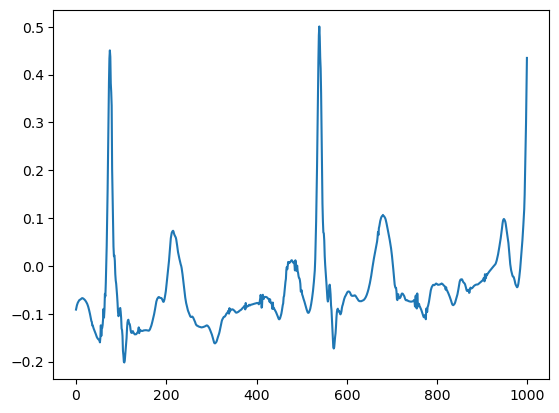

In [26]:
class NoisyECGDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        signal = self.data[index]
        noisy_signal = self.add_random_noise(signal)
        return noisy_signal

    def add_random_noise(self, signal):
        signal = signal.numpy()
        
        magnitude_warp = np.random.normal(1, 0.1, signal.shape)
        signal = signal + magnitude_warp*signal# magnitude warp

        scale = np.random.normal(1, 0.05)
        signal = scale*signal  # rescale

        noise = np.random.normal(0, 0.01, signal.shape)
        signal = noise + signal  # static noise

        return torch.from_numpy(signal)

#print(X_train.shape)
train_dataset = NoisyECGDataset(X_train).data
plt.plot(train_dataset[0,:,0])
X_train=train_dataset
print(X_train.shape)

In [25]:
from tqdm import tqdm

import torch
import torchvision.transforms as transforms

# Calculate mean and standard deviation of your training data
#mean = X_train.mean()
#std = X_train.std()

## Define a normalization transform
#transform = transforms.Compose([
#    transforms.ToTensor(),  # Convert data to tensor (if not already)
#    transforms.Normalize(mean, std)  # Normalize the data
#])

## Apply the normalization transform to your training and test data
#normalized_X_train = transform(X_train)
#normalized_X_test = transform(X_test)




print(torch.cuda.is_available())
device=torch.device('cpu')
# Initialize the model         #10000 15000 512
epochs=30
num_classes = 1
learn_rate=0.00005
model=SimpleCNN()
batch=4
# Define loss function and optimizer
#class_weight[1] *= 2.0
#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weight[1]).clone().detach())
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learn_rate)
#X_train_tensor_normalized=sc.transform(X_train_tensor)
# Create DataLoader for training and testing
print("1")
train_dataset = TensorDataset(X_train.permute(0,2,1), y_train)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
total_train_batches = len(train_loader)
valid_dataset = TensorDataset(X_test.permute(0,2,1), y_test)
valid_loader = DataLoader(valid_dataset, batch_size=batch)


best_validation_loss = float('inf')
train_loss_values = []
train_accuracy_values = []
average_validation_loss=0.0
average_train_loss=0.0
valid_loss_values=[]
valid_accuracy_values=[]
metrics=[]
plt.ion()
total_loss=0.0
early_stopping = EarlyStopping(patience=6, verbose=True)
# training and testing
pom=0
for epoch in range(epochs):
    total_loss = 0.0
    correct_predictions = 0
    correct_predictions_for_1=0
    correct_predictions_for_0=0
    total_samples = 0
    with tqdm(total=total_train_batches, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            #print(outputs)
            #print(labels)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_samples += len(labels)
            pred = outputs>0.5
            correct_predictions += (pred == labels).all(dim=1).sum().item()
            correct_predictions_for_1 += np.sum((pred.numpy() == 1) & (labels.numpy() == 1))
            correct_predictions_for_0 += np.sum((pred.numpy() == 0) & (labels.numpy() == 0))
            # Update the progress bar
            pbar.set_postfix({'Training Loss': f'{total_loss / total_samples:.4f}'})
            pbar.update(1)
    print(correct_predictions_for_1)
    print(correct_predictions_for_0)
    average_train_loss = total_loss / total_samples
    epoch_loss = total_loss / total_samples
    epoch_acc = float(correct_predictions) / total_samples
    train_loss_values.append(epoch_loss)
    train_accuracy_values.append(epoch_acc)
    print(f'{epoch + 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():  # Disable gradient computation during validation
        for inputs, labels in valid_loader:
            outputs = model(inputs) 
            loss = criterion(outputs, labels.float())
            total_loss += loss.item()
            total_samples += len(labels)
            pred = (outputs > 0.5)
            correct_predictions += (pred == labels).all(dim=1).sum().item()
    average_validation_loss = total_loss / total_samples
    epoch_loss = total_loss/ total_samples
    epoch_acc = float(correct_predictions) / total_samples
    valid_loss_values.append(epoch_loss)
    valid_accuracy_values.append(epoch_acc)
    print(f'Epoch {epoch + 1} Validation Loss: {epoch_loss:.4f} Validation Acc: {epoch_acc:.4f}')
    early_stopping(average_validation_loss, model)
    if average_validation_loss < best_validation_loss:
        best_validation_loss = average_validation_loss
        torch.save(model.state_dict(), 'best_model.pth')  
    if early_stopping.early_stop:
        print("Early stopping: Validation loss did not improve in the last", early_stopping.patience, "epochs.")
        break

plt.ioff()
plt.figure()

# Plot Training Loss
plt.subplot(2, 1, 1)
plt.plot(train_loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 1, 2)
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot Validation Loss and Validation Accuracy
plt.figure()
plt.plot(valid_loss_values, label='Validation Loss')
plt.plot(valid_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.show()

False
1


Epoch 1/30: 100%|██████████| 3648/3648 [02:14<00:00, 27.19batch/s, Training Loss=0.1642]


2545
6987
1 Loss: 0.1642 Acc: 0.6532
Epoch 1 Validation Loss: 0.1611 Validation Acc: 0.7330


Epoch 2/30: 100%|██████████| 3648/3648 [02:15<00:00, 26.93batch/s, Training Loss=0.1583]


4573
6687
2 Loss: 0.1583 Acc: 0.7717
Epoch 2 Validation Loss: 0.1555 Validation Acc: 0.7498


Epoch 3/30: 100%|██████████| 3648/3648 [02:17<00:00, 26.61batch/s, Training Loss=0.1496]


5354
6449
3 Loss: 0.1496 Acc: 0.8089
Epoch 3 Validation Loss: 0.1541 Validation Acc: 0.7611


Epoch 4/30: 100%|██████████| 3648/3648 [02:12<00:00, 27.54batch/s, Training Loss=0.1482]


5428
6496
4 Loss: 0.1482 Acc: 0.8172
Epoch 4 Validation Loss: 0.1570 Validation Acc: 0.7867
EarlyStopping counter: 1 out of 6


Epoch 5/30: 100%|██████████| 3648/3648 [02:14<00:00, 27.22batch/s, Training Loss=0.1471]


5531
6545
5 Loss: 0.1471 Acc: 0.8276
Epoch 5 Validation Loss: 0.1531 Validation Acc: 0.7929


Epoch 6/30: 100%|██████████| 3648/3648 [02:12<00:00, 27.49batch/s, Training Loss=0.1466]


5629
6543
6 Loss: 0.1466 Acc: 0.8342
Epoch 6 Validation Loss: 0.1542 Validation Acc: 0.7916
EarlyStopping counter: 1 out of 6


Epoch 7/30: 100%|██████████| 3648/3648 [02:12<00:00, 27.53batch/s, Training Loss=0.1461]


5612
6589
7 Loss: 0.1461 Acc: 0.8361
Epoch 7 Validation Loss: 0.1537 Validation Acc: 0.7898
EarlyStopping counter: 2 out of 6


Epoch 8/30: 100%|██████████| 3648/3648 [02:07<00:00, 28.69batch/s, Training Loss=0.1455]


5689
6604
8 Loss: 0.1455 Acc: 0.8424
Epoch 8 Validation Loss: 0.1540 Validation Acc: 0.7898
EarlyStopping counter: 3 out of 6


Epoch 9/30: 100%|██████████| 3648/3648 [02:17<00:00, 26.52batch/s, Training Loss=0.1450]


5726
6627
9 Loss: 0.1450 Acc: 0.8466
Epoch 9 Validation Loss: 0.1529 Validation Acc: 0.7754


Epoch 10/30: 100%|██████████| 3648/3648 [02:16<00:00, 26.65batch/s, Training Loss=0.1449]


5702
6641
10 Loss: 0.1449 Acc: 0.8459
Epoch 10 Validation Loss: 0.1532 Validation Acc: 0.7923
EarlyStopping counter: 1 out of 6


Epoch 11/30: 100%|██████████| 3648/3648 [02:18<00:00, 26.35batch/s, Training Loss=0.1441]


5785
6669
11 Loss: 0.1441 Acc: 0.8535
Epoch 11 Validation Loss: 0.1536 Validation Acc: 0.7642
EarlyStopping counter: 2 out of 6


Epoch 12/30: 100%|██████████| 3648/3648 [02:15<00:00, 26.88batch/s, Training Loss=0.1438]


5810
6703
12 Loss: 0.1438 Acc: 0.8575
Epoch 12 Validation Loss: 0.1547 Validation Acc: 0.7941
EarlyStopping counter: 3 out of 6


Epoch 13/30: 100%|██████████| 3648/3648 [02:15<00:00, 26.92batch/s, Training Loss=0.1434]


5885
6687
13 Loss: 0.1434 Acc: 0.8616
Epoch 13 Validation Loss: 0.1532 Validation Acc: 0.7954
EarlyStopping counter: 4 out of 6


Epoch 14/30:  45%|████▍     | 1627/3648 [01:00<01:15, 26.74batch/s, Training Loss=0.1429]


KeyboardInterrupt: 

In [35]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

print(y_test.shape)

torch.Size([15000, 5000, 12])
torch.Size([15000, 1])
torch.Size([1708, 5000, 12])
torch.Size([1708, 1])


In [26]:
model = SimpleCNN()  # Instantiate the model with the same architecture as during training
model.load_state_dict(torch.load('best_model.pth')) 


test_dataset = TensorDataset(X_valid.permute(0, 2, 1), y_valid)
test_loader = DataLoader(test_dataset, batch_size=, shuffle=False)

# Step 3: Test the Model on the Test Set
model.eval()  # Set the model to evaluation mode
total_correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted_labels = (outputs > 0.5).float()  # Threshold the output probabilities
        total_correct_predictions += (predicted_labels == labels).all(dim=1).sum().item()
        total_samples += len(labels)

# Calculate Test Accuracy
test_accuracy = total_correct_predictions / total_samples
print(f'Test Accuracy: {test_accuracy:.2f}')


ZeroDivisionError: division by zero

In [21]:
y_train=y_train.unsqueeze(1)
y_test=y_test.unsqueeze(1)